<a href="https://colab.research.google.com/github/LukasStankevicius/ea/blob/main/meteo_rest_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Užduotis
Parašyti python programą (galima užduotį atlikti ir pateikti tiek .py tiek .ipynb failuose),  kuri per REST API nusiskaito https://api.meteo.lt/ duomenis ir išpildo šiuos punktus:  
1) Duomenų nuskaitymas vyksta per atskirą klasę. Į šį objektą nurdoma vietovės kodas, API URL. Ši klasė turi turėti du metodus:  
        a) Istorinių duomenų nuskaitymas už nurodytą laiko intervalą nuo - iki;  
        b) Prognozės duomenų nuskaitymas;  
    Abiem atvejais duomenys turėtų būti gražinami pandas.DataFrame  formatu, kur indeksas yra laikas (pd.DatetimeIndex) su įvertinta laiko zona;

### Apie įgyvendinimą
Istorinių duomenų nuskaitymui reikia stoties kodo, bet duodamas tik vietovės kodas. Taigi dabar randama artimiausia stotis nuo vietovės pagal duotas koordinates. Ateityje būtų galima interpoliuoti aplink esančių stočių rezultatus.

Laikoma, kad nebus viršyta 20.000 užklausų per vieną parą iš vieno IP adreso, ir kad REST API veiks tinkamai.

Taip pat laikoma, kad duomenys gaunami tvarkingi: t. y. valandiniai, be tuščių reikšmių.

Autorius: Lukas Stankevičius, 2024-03-28

In [ ]:
import requests
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd
from datetime import date, timedelta
from tqdm import tqdm


def get_stoties_kodas_for_vietoves_kodas(vietoves_kodas: str, api_url: str) -> str:
    # finding the nearest station `stoties_kodas` for a given `vietoves_kodas`
    # first, find all available stations
    response = requests.get(f"{api_url}stations")
    df_stations = (pd
                   .DataFrame.from_records(response.json())
                   .assign(latitude=lambda x: x['coordinates'].str['latitude'],
                           longitude=lambda x: x['coordinates'].str['longitude'])
                   )
    # second, get coordinates of the given vietoves_kodas
    response = requests.get(f"{api_url}places/{vietoves_kodas}")
    ans = response.json()
    vietoves_coor = np.array([ans['coordinates']['latitude'], ans['coordinates']['longitude']])
    # third, get the nearest station code:
    # note that this works correctly only in Lithuania, as it is like a plane, not sphere
    idx = cdist([vietoves_coor], df_stations[['latitude', 'longitude']].values).argmin()
    stoties_kodas = df_stations['code'].tolist()[idx]
    print(f'For {vietoves_kodas} will use observations from {stoties_kodas} station')
    return stoties_kodas


def reindex_and_interpolate(df, freq='H'):
    return (df
            .reindex(pd.DatetimeIndex(pd.date_range(df.index.min(), df.index.max(), freq=freq), tz='UTC'))
            .interpolate()
            )


class Reader:
    def __init__(self, vietoves_kodas='vilnius', api_url="https://api.meteo.lt/v1/"):
        response = requests.get(f"{api_url}places")
        vietoviu_kodai = set(pd.DataFrame.from_records(response.json())['code'].tolist())
        assert vietoves_kodas in vietoviu_kodai, f"Tokio vietovės kodo nėra: {vietoves_kodas}"
        self.url_progrnoze = f"{api_url}places/{vietoves_kodas}/forecasts/long-term"
        stoties_kodas = get_stoties_kodas_for_vietoves_kodas(vietoves_kodas, api_url)
        self.base_url_istorija = f"{api_url}stations/{stoties_kodas}/observations"

    def istoriniu_nuskaitymas(self, data_nuo: date, data_iki: date) -> pd.DataFrame:
        assert data_nuo <= date.today(), \
            f"Negalima gauti istorinių duomenų nuo {data_nuo.isoformat()}, nurodykite anskstesnę datą"
        assert data_iki <= date.today(), \
            f"Negalima gauti istorinių duomenų iki {data_iki.isoformat()}, nurodykite šiandien arba anskstesnę datą"

        results = []
        for i in tqdm(pd.date_range(data_nuo, data_iki, freq='D'), desc='Getting history data'):
            url_history_date = f"{self.base_url_istorija}/{i.date().isoformat()}"
            response = requests.get(url_history_date)
            df_ = pd.DataFrame.from_records(response.json()['observations'])
            results.append(df_)
        df = (pd
              .concat(results)
              .assign(observationTimeUtc=lambda x: pd.to_datetime(x['observationTimeUtc'], utc=True))
              .set_index('observationTimeUtc')
              )
        return df

    def prognozes_nuskaitymas(self) -> pd.DataFrame:
        response = requests.get(self.url_progrnoze)
        df = (pd
              .DataFrame.from_records(response.json()['forecastTimestamps'])
              .assign(forecastTimeUtc=lambda x: pd.to_datetime(x['forecastTimeUtc'], utc=True))
              .set_index('forecastTimeUtc')
              )
        return df


In [ ]:
reader = Reader(vietoves_kodas='klaipeda')
df_prognoze = reader.prognozes_nuskaitymas()
# the following takes about 4 min. for whole year data, be patient.
df_istorija = reader.istoriniu_nuskaitymas(date.today() - timedelta(days=365), date.today())

For klaipeda will use observations from klaipedos-ams station


Getting history data: 100%|██████████| 366/366 [04:57<00:00,  1.23it/s]


  # Turinys <a id='main' name="main"></a>

  2)  Nuskaičius istorinius duomenis už praeitus metus (laikotarpis nuo šiandien iki metai atgal) suskaičiuoti ir atvaizduoti šiuos rodiklius:    
     - a)  [Vidutinė metų temperatūra, oro drėgmė;](#vid_temp_dreg)  
     - b)  [Vidutinė metų dienos, ir nakties temperatūra priimant kad skaičiuojama LT laiko zonoje ir diena yra tarp 08:00 ir 20:00;](#vid_dienos_nakties)  
     - c)  [Kiek savaitgalių (šeštadienis/sekmadienis - 1 savaitgalis) per šį laikotarpį buvo prognozuojama kad lis;](#kiek_savaitgaliu_lijo)  
  3) [Nuskaičius prognozės duomenis juos apjungti su istoriniais. Atvaizduoti grafiką, kuris rodo paskutinės savaitės išmatuotą temperatūrą ir ateinančio periodo prognozuojama temperatūrą.](#apjungimas)  
  4) [Visi nuskaityti duomenys yra valandiniai. Parašyti funkciją, į kurią padavus temperatūros pandas.Series suskaičiuotų tarpines reikšmes ir pagražintų rezultatą pandas.Series kurio dažnis yra 5 minutės. Tarpines reikšmes interpoliuoti.](#5min)

## 2a) Vidutinė metų temperatūra, oro drėgmė; <a id='vid_temp_dreg' name="vid_temp_dreg"></a>[⌂](#main)

In [ ]:
print(f"Vidutinė metų temperatūra yra {df_istorija['airTemperature'].mean():3.3f}°C")
print(f"Vidutinė oro drėgmė yra {df_istorija['relativeHumidity'].mean():3.3f}%")

Vidutinė metų temperatūra yra 9.256°C
Vidutinė oro drėgmė yra 79.795%


## 2b) Vidutinė metų dienos, ir nakties temperatūra priimant kad skaičiuojama LT laiko zonoje ir diena yra tarp 08:00 ir 20:00;<a id='vid_dienos_nakties' name="vid_dienos_nakties"></a>[⌂](#main)

Programa veikia UTC laiko juostoje, o Lietuvoje laikas yra UTC+2, vadinasi diena UTC juostoje bus nuo 6:00 iki 18:00.

In [ ]:
day_mask = (df_istorija.index.hour >= 6) & (df_istorija.index.hour < 18)

print(f"Vidutinė metų dienos temperatūra Lietuvoje yra {df_istorija.loc[day_mask, 'airTemperature'].mean():3.3f}°C")
print(f"Vidutinė metų nakties temperatūra Lietuvoje yra {df_istorija.loc[~day_mask, 'airTemperature'].mean():3.3f}°C")


Vidutinė metų dienos temperatūra Lietuvoje yra 10.288°C
Vidutinė metų nakties temperatūra Lietuvoje yra 8.224°C


## 2c) Kiek savaitgalių (šeštadienis/sekmadienis - 1 savaitgalis) per šį laikotarpį buvo prognozuojama kad lis;<a id='kiek_savaitgaliu_lijo' name="kiek_savaitgaliu_lijo"></a>[⌂](#main)

In [ ]:
n_weeks = (
    df_istorija
    .loc[lambda x: x.index.weekday.isin([5, 6]) & (x['precipitation'] > 0)]
    .assign(weekend_id = (
        lambda x: x.index.isocalendar().week.astype(str) + "_" +
        x.index.isocalendar().year.astype(str))
    )
    .loc[:, 'weekend_id']
    .nunique()
    )
print(f"Per šį laikotarpį buvo prognozuojama, kad lis {n_weeks} savaitgalius.")

Per šį laikotarpį buvo prognozuojama, kad lis 37 savaitgalius.


## 3) Nuskaičius prognozės duomenis juos apjungti su istoriniais. Atvaizduoti grafiką, kuris rodo paskutinės savaitės išmatuotą temperatūrą ir ateinančio periodo prognozuojama temperatūrą. <a id='apjungimas' name="apjungimas"></a>[⌂](#main)

Text(2024-03-28 14:53:15.588923, 0, 'Dabar')

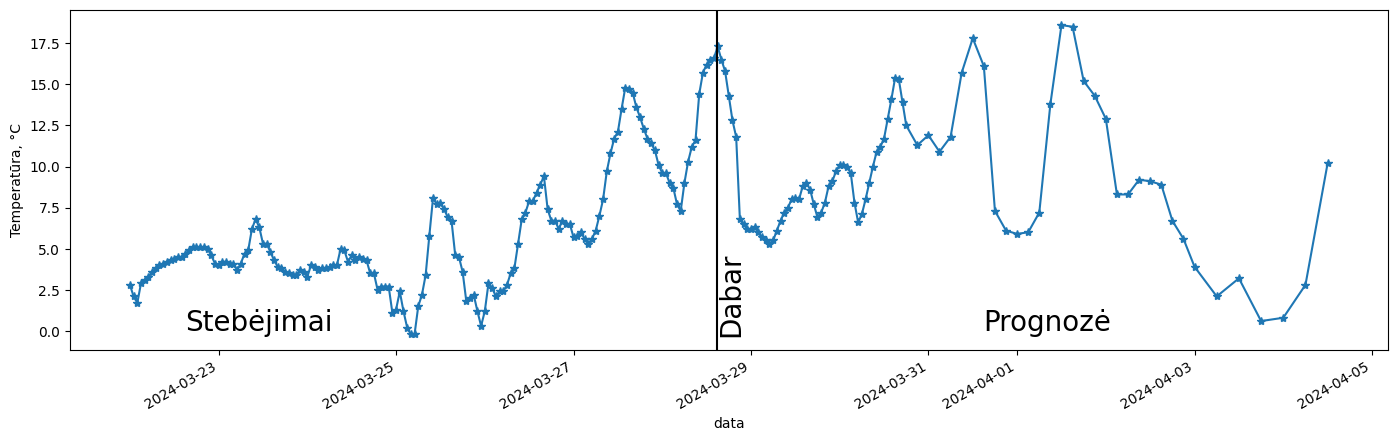

In [ ]:
both = (pd
        .concat(
            [
                df_istorija.rename_axis('TimeUtc', axis=0),
                 (df_prognoze
                  .rename_axis('TimeUtc', axis=0)
                  .loc[lambda x: ~x.index.isin(df_istorija.index)]
                  )
                 ], axis=0)
        .sort_index()
        )
ax = (both
      .loc[lambda x: x.index.date > (date.today() - timedelta(days=7))]
      .loc[:, 'airTemperature']
      .plot(style='-*', figsize=(17, 5), xlabel='data', ylabel='Temperatūra, °C')
)
ax.axvline(pd.Timestamp.now(), color='k')
ax.text(pd.Timestamp.now() + timedelta(days=3), 0, 'Prognozė',  fontsize=20)
ax.text(pd.Timestamp.now() - timedelta(days=6), 0, 'Stebėjimai',  fontsize=20)
ax.text(pd.Timestamp.now(), 0, "Dabar", rotation=90,  fontsize=20)

## 4) Visi nuskaityti duomenys yra valandiniai. Parašyti funkciją, į kurią padavus temperatūros pandas.Series suskaičiuotų tarpines reikšmes ir pagražintų rezultatą pandas.Series kurio dažnis yra 5 minutės. Tarpines reikšmes interpoliuoti.<a id='5min' name="5min"></a>[⌂](#main)

In [ ]:
both_5min_temp = reindex_and_interpolate(both['airTemperature'], freq='5min')
both_5min_temp

2023-03-29 00:00:00+00:00     0.500000
2023-03-29 00:05:00+00:00     0.475000
2023-03-29 00:10:00+00:00     0.450000
2023-03-29 00:15:00+00:00     0.425000
2023-03-29 00:20:00+00:00     0.400000
                               ...    
2024-04-04 11:40:00+00:00     9.788889
2024-04-04 11:45:00+00:00     9.891667
2024-04-04 11:50:00+00:00     9.994444
2024-04-04 11:55:00+00:00    10.097222
2024-04-04 12:00:00+00:00    10.200000
Freq: 5T, Name: airTemperature, Length: 107281, dtype: float64